https://towardsdatascience.com/gaussian-mixture-model-clearly-explained-115010f7d4cf/

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Multivariate Normal Distribution

In [5]:
mean1 = [0, 0]
mean2 = [0, 3]

cov1 = [[1, 2], 
        [2, 7]]
cov2 = [[.5, .4], 
        [.4, .5]]

In [6]:
# Generate data from the mean and covariance
data1 = np.random.multivariate_normal(mean1, cov1, size=1000)
data2 = np.random.multivariate_normal(mean2, cov2, size=1000)

In [7]:
# Set the mean and covariance
mean1 = [0, 0]
mean2 = [2, 0]
cov1 = [[1, .7], [.7, 1]]
cov2 = [[.5, .4], [.4, .5]]

# Generate data from the mean and covariance
data1 = np.random.multivariate_normal(mean1, cov1, size=1000)
data2 = np.random.multivariate_normal(mean2, cov2, size=1000)

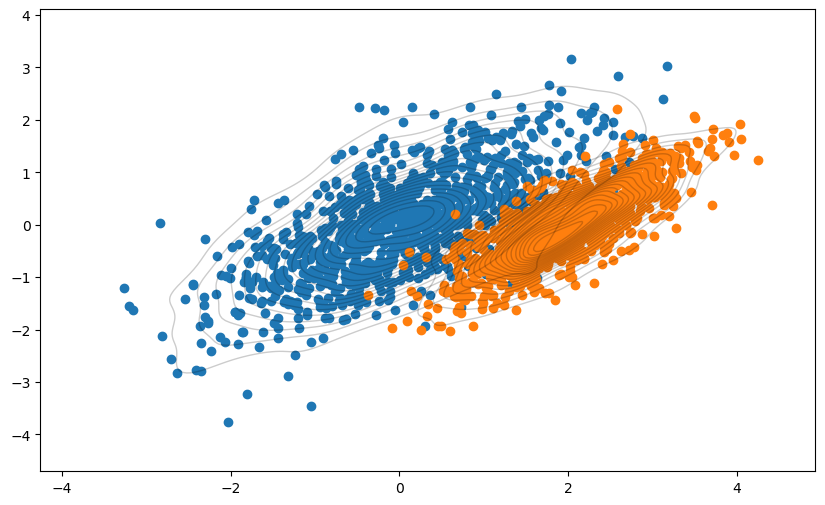

In [8]:
plt.figure(figsize=(10,6))

plt.scatter(data1[:,0],data1[:,1])
plt.scatter(data2[:,0],data2[:,1])

sns.kdeplot(x=data1[:, 0], y=data1[:, 1], levels=20, linewidths=1, color='k', alpha=0.2)
sns.kdeplot(x=data2[:, 0], y=data2[:, 1], levels=20, linewidths=1, color='k', alpha=0.2)


plt.grid(False)
plt.show()

Create 1D generated data

In [9]:
n_samples = 100
mu1, sigma1 = -5, 1.2 
mu2, sigma2 = 5, 1.8 
mu3, sigma3 = 0, 1.6 

x1 = np.random.normal(loc = mu1, scale = np.sqrt(sigma1), size = n_samples)
x2 = np.random.normal(loc = mu2, scale = np.sqrt(sigma2), size = n_samples)
x3 = np.random.normal(loc = mu3, scale = np.sqrt(sigma3), size = n_samples)

X = np.concatenate((x1,x2,x3))

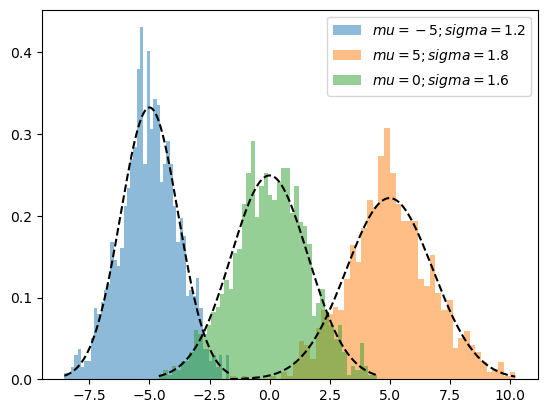

In [14]:
from scipy.stats import norm

def plot_pdf(mu,sigma,label,alpha=0.5,linestyle='k--',density=True):
    """
    Plot 1-D data and its PDF curve.

    """
    # Compute the mean and standard deviation of the data

    # Plot the data

    X = norm.rvs(mu, sigma, size=1000)

    plt.hist(X, bins=50, density=density, alpha=alpha,label=label)

    # Plot the PDF
    x = np.linspace(X.min(), X.max(), 1000)
    y = norm.pdf(x, mu, sigma)
    plt.plot(x, y, linestyle)

plot_pdf(mu1,sigma1,label=r"$mu={}  ;  sigma={}$".format(mu1,sigma1))
plot_pdf(mu2,sigma2,label=r"$mu={}  ;  sigma={}$".format(mu2,sigma2))
plot_pdf(mu3,sigma3,label=r"$mu={}  ;  sigma={}$".format(mu3,sigma3))
plt.legend()
plt.show()